# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
import glob
import os
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from IPython.display import display
from calendar import monthrange
sns.set_context('notebook')
sns.set()
np.set_printoptions(threshold='nan')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
def pretty_pie(title, vals, lbls, num_colors=10):

    rcParams['axes.titlepad'] = 20 
    rcParams['figure.figsize'] = 7, 7
    sns.set_palette("Set2", num_colors, 1.0)

    exp = list()

    i=0
    for k in lbls:
        exp.append(0.015 * i**2)
        i+=1
    
    patches, text, autotext = plt.pie(vals, labels=lbls, explode=exp, pctdistance=0.8, textprops={'fontsize':14}, autopct='%1.1f%%', shadow=False, startangle=0)

    for t in text:
        t.set_fontsize(14)

    plt.title(title, 
              horizontalalignment='center',
              fontsize=20, 
              style='oblique', 
              weight='bold', 
              variant='small-caps')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show();

In [4]:
def pretty_bar(vals, xlabels, xtitle, ytitle, width=0.6, figwidth=5):
    rcParams['figure.figsize'] = figwidth, 5
    plt.bar(range(len(xlabels)), vals, tick_label=xlabels, width=width, align='center')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.grid(axis='x')
    plt.show()
    
def pretty_bar_stacked(vals1, vals2, xlabels, xtitle, ytitle, title, width=0.6, figwidth=5):
    rcParams['figure.figsize'] = figwidth, 5
    plt.bar(range(len(xlabels)), vals1, width=width, align='center')
    plt.bar(range(len(xlabels)), vals2, bottom=vals1, width=width, align='center')
    plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
    plt.legend(('Survived', 'Died'), bbox_to_anchor=(1.1, 1.05), fontsize=14)
    plt.xlabel(xtitle)
    plt.get
    plt.ylabel(ytitle)
    plt.grid(axis='x')
    plt.title(title, 
              horizontalalignment='center',
              fontsize=20, 
              style='oblique', 
              weight='bold', 
              variant='small-caps')
    plt.show()

In [5]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

# Solution
## Explanation

For the first task, we tried to factorize as much as possible our code to be able to read all 3 different set of data with heterogeneous convention, using only one function.

We defined 4 helper function:
1. *rename* : Rename the column we are intersted in, with the same convention.
2. *take_non_nan_total* : Return the non NaN value from either of the two arguments.
3. *clamp*: Make sure the value is contained in the interval and return it if it's not the case return 0.
4. *clamp_case_death*: Apply clamp with different interval wether it's a death of a case.


Now, we are going to desribe in more details our main method: *import_ebola*. We will use at least 4 rows: 3 rows for the cases (the new cases) and 1 row for the deaths (the total new deaths). For Guinea/Liberia, we used also the deaths/cases of health care workers(HCW). For Sierra Leone, we used for the deaths the cumulative one and the ETC deaths. Our **first** assumption is that the data contained in Totals or National is sufficient for this task.

The first for loop let us iterate all the file we are intersted in. Then we read the csv file, make sure to fill the NaN values. Then, we will clamp the values of death and case. It's our **second** assumption to clean the data: the new cases shouldn't exceed 200 (and be negative) and the cumulative deaths shouldn't exceed 2000 (and be negative). Hence, we get per file a Data Frame:

![alt text](Images/img1.png)

We then simply concatenate each Data Frame together to get *df_total*, the data frame for one country. Then we will try to "de-cumulate" the rows that need it (deaths of Sierra Leone), to make sure that all the data (deaths and cases) are non-cumulative. Doing this will ease our work as all the data will have the same format. To achieve this result we will first extract the cumulative rows. Then, we use the diff function to "de-cumulate". We then make our **third** assumption, if when making the difference of two rows we get a negative result (the cumulative number of deaths decrease from one day to the other one), we clamp it. Finally we merge it with the initial Data Frame and we make sure to select the good fields for each row (the non NaN one):

![alt text](Images/img2.png) From, to : ![alt text](Images/img3.png)


We can see our **fourth** assumption above. The first values are kept the same when we de-cumulate. One other choice would have been to set them to zero for example; but as there is no data before we can still considerate those first value as the "new" deaths for this date.
We then select the columns needed.

We then rename every column to the appropriate name. Now, we pivot the data frame; to have the data in the end in the best form possible:

![alt text](Images/img4.png)

Then we create a new Data frame containing the delta of days of each month by taking the max of each days per month. This is our **fifth** assumption, the number of days per month (to have the average) can be obtained as explained above; this have the advantage that if we have only one date we won't have to divide by 31. We then merge this with the other data frame and divide by that new column every other column after grouping each row by the month number. After some details we are finally done for one country!

To get the final result we just concat each of the data frame from the 3 countries. 

![alt text](Images/img5.png)

## Helper functions and regexes

In [6]:
guinea = "Data/ebola/guinea_data/"
guineaRows = ['New cases of suspects','New cases of probables','New cases of confirmed',
              'New deaths registered','New cases of confirmed among health workers',
              'New deaths registered among health workers']
liberia = "Data/ebola/liberia_data/"
liberiaRows = ['New Case/s (Suspected)','New Case/s (Probable)','New case/s (confirmed)',
               'Newly reported deaths','Newly Reported Cases in HCW','Total death/s in suspected cases']
sl = "Data/ebola/sl_data/"
slRows = ['new_suspected','new_probable','new_confirmed','death_suspected','death_probable',
          'death_confirmed','etc_new_deaths']

monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

def rename(row):
        if(row.lower().find('death') >= 0):
            return 'New Deaths'
        else:
            return 'New Cases'
        
def take_non_nan_total(x,y):
    if(np.isnan(y)):
        return x
    else:
        return y

def clamp(x,lowerThreshold = 0, upperThreshold = 2000):
    if(x<lowerThreshold or x>upperThreshold):
        return 0
    else:
        return x

def clamp_case_death(x,y):
    if(y.lower().find('death') >= 0):
        return clamp(x)
    else:
        return clamp(x,0,200)

## Loading, cleaning and aggregating routine

In [7]:
def import_ebola(nameCountry,nameDir,dateColName,descriptionColName,totalColName,descriptionRegexp,cumParam = []):
    df_list = []
    
    #Read the files in nameDir
    for file in os.listdir(nameDir):
        df = pd.read_csv(nameDir+file,parse_dates=[dateColName])
        df = df[[dateColName,descriptionColName,totalColName]]
        
        #Rename every row so that it's easier
        df = df.rename(columns={dateColName:'Date',descriptionColName:'Description',totalColName:'Totals'})
        
        #Keep only the interesting rows and clean data
        df = df[df.Description.isin(descriptionRegexp)]
        df = df.fillna(0)
        df.Totals = df.Totals.apply(pd.to_numeric)
        df.Totals = df.apply(lambda x: clamp_case_death(x['Totals'],x['Description']),axis = 1)
        if(np.any(df.Totals > 0)):
            df_list.append(df)
        
    df_total = pd.concat(df_list)
    df_total = df_total.sort_values(['Date','Description'])
    
    #"De-cumulate" the data if needed
    if(len(cumParam) > 0):
        n = len(cumParam)
        df_temp = df_total[df_total.Description.isin(cumParam)].copy()
        first_val = df_temp[:n]
        df_temp.Totals = df_temp.Totals.diff(n)
        df_temp = df_temp[n:]
        df_temp = pd.concat([first_val,df_temp])
        df_temp['Totals'] = df_temp.apply(lambda x: clamp(x['Totals']),axis = 1)
        df_total = pd.merge(df_total,df_temp,how='outer',on = ['Date','Description'])
        df_total['Totals'] = df_total.apply(lambda x: take_non_nan_total(x['Totals_x'], x['Totals_y']), axis=1)
        df_total = df_total[['Date','Description','Totals']]

    #Rename each types of cases/deaths into "New Cases"/"New Deaths"
    df_total.Description = df_total.Description.apply(rename)
    df_total = df_total.groupby([df_total.Date,df_total.Description]).sum()
    df_total = df_total.reset_index()
    df_total = df_total.pivot(index='Date', columns='Description', values='Totals')    
    df_total = df_total.fillna(0)

    #Get the number of days in a month by taking the max of days in Date
    df_day = df_total.copy()
    df_day['Day'] = df_day.index.day
    df_day = df_day[['Day']]
    df_day = df_day.groupby(df_day.index.month).max()
    
    #Group by month
    df_total = df_total.groupby(df_total.index.month).sum()
    
    #Do the average and keep only the columns of interest
    df_total = df_total.merge(df_day,left_index =True,right_index=True)    
    df_total[['New Cases','New Deaths']] = df_total[['New Cases','New Deaths']].div(df_total['Day'], axis=0)
    df_total = df_total.drop('Day',1)
    
    #Add a column country to make it easier to group by after
    df_total['Country'] = nameCountry        
    df_total = df_total.groupby([df_total.Country,df_total.index]).sum()
    return df_total

df_guinea = import_ebola('Guinea',guinea,'Date','Description','Totals',guineaRows)
df_liberia = import_ebola('Liberia',liberia,'Date','Variable','National',liberiaRows)
df_sl = import_ebola('Sierra Leone',sl,'date','variable','National',slRows,['death_confirmed','death_suspected','death_probable'])

#Concat each Data Frame and group by country,month
df = pd.concat([df_guinea,df_liberia,df_sl], axis=0)
df.index = pd.MultiIndex.from_tuples([(x[0], monthDict.get(x[1])) for x in df.index],names = ['Country','Month'])
display(df)

Description         New Cases  New Deaths
Country      Month                       
Guinea       Aug     4.161290    0.483871
             Sep    10.700000    1.900000
             Oct    36.000000   15.000000
Liberia      Jun     1.655172    2.068966
             Jul     3.884615    9.269231
             Aug    12.250000   41.964286
             Sep    52.200000  281.733333
             Oct    37.322581  116.580645
             Nov    13.400000    6.733333
             Dec    36.500000    0.000000
Sierra Leone Aug    16.225806   14.032258
             Sep    39.333333    5.700000
             Oct    64.064516   31.032258
             Nov    54.482759   15.137931
             Dec    34.166667   37.166667

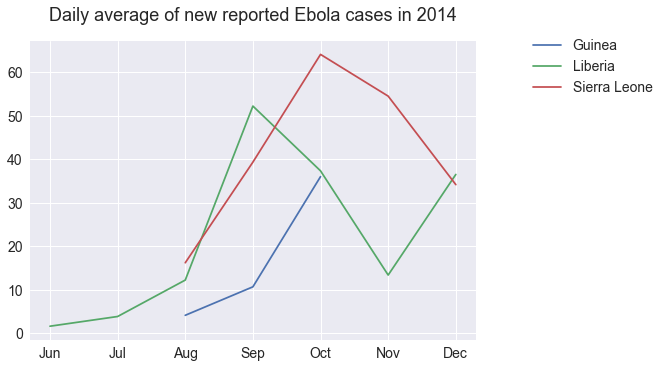

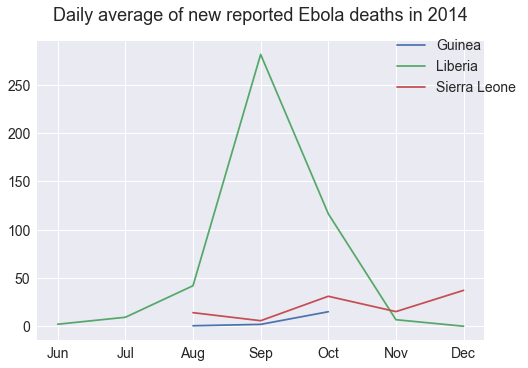

In [8]:
rcParams['axes.titlepad'] = 20 
complete_index = ['Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec']

df.sort_index(axis=1, inplace=True)

guinea_data = df.loc['Guinea'].reindex(complete_index)
liberia_data = df.loc['Liberia'].reindex(complete_index)
sierra_leone_data = df.loc['Sierra Leone'].reindex(complete_index)

s = len(complete_index)
plt.plot(range(s), guinea_data['New Cases'])
plt.plot(range(s), liberia_data['New Cases'])
plt.plot(range(s), sierra_leone_data['New Cases'])
plt.title("Daily average of new reported Ebola cases in 2014", fontsize=18)
plt.xticks(range(s), complete_index, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Guinea', 'Liberia', 'Sierra Leone'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.show()

plt.plot(range(s), guinea_data['New Deaths'])
plt.plot(range(s), liberia_data['New Deaths'])
plt.plot(range(s), sierra_leone_data['New Deaths'])
plt.title("Daily average of new reported Ebola deaths in 2014", fontsize=18)
plt.xticks(range(s), complete_index, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Guinea', 'Liberia', 'Sierra Leone'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.show()

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [9]:
path = DATA_FOLDER + '/microbiome/'

# There should be 9 files of data
all_mid_files = sorted(glob.glob(os.path.join(path, "MID*")))
print(all_mid_files)
print('Found '+str(len(all_mid_files))+' csv files for data')

# There should be 1 file of metadata
metadata = pd.read_excel(path + 'metadata.xls')

# We concatenate the data files using the keys attribute to include information about the file
data = pd.concat(
    (pd.read_excel(file, header=None) for file in all_mid_files), 
    ignore_index=False, 
    keys=("MID"+str(i) for i in range(1,10)))

metadata = metadata.set_index('BARCODE')
data.reset_index(level=0, inplace=True)
data.columns = ['BARCODE', 'MICROBIOME', 'COUNTS']

# Merge the two tables, broadcasting the metadata across all the data rows
combined_data = data.merge(metadata, how='left', left_on='BARCODE', right_index=True)

# Configure tags
combined_data.SAMPLE = combined_data.SAMPLE.replace(np.nan, 'unknown')

# Set a unique index
combined_data = combined_data.set_index(['BARCODE', 'MICROBIOME'])
combined_data.GROUP = combined_data.GROUP.astype('category')

print("Is index unique ? -> " + str(combined_data.index.is_unique))
display(combined_data)

['Data/microbiome\\MID1.xls', 'Data/microbiome\\MID2.xls', 'Data/microbiome\\MID3.xls', 'Data/microbiome\\MID4.xls', 'Data/microbiome\\MID5.xls', 'Data/microbiome\\MID6.xls', 'Data/microbiome\\MID7.xls', 'Data/microbiome\\MID8.xls', 'Data/microbiome\\MID9.xls']
Found 9 csv files for data
Is index unique ? -> True


COUNTS  \
BARCODE MICROBIOME                                                   
MID1    Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       7   
        Archaea "Crenarchaeota" Thermoprotei Desulfuroc...       2   
        Archaea "Crenarchaeota" Thermoprotei Sulfolobal...       3   
        Archaea "Crenarchaeota" Thermoprotei Thermoprot...       3   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...       7   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...       1   
        Archaea "Euryarchaeota" "Methanomicrobia" Metha...       1   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       1   
        Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...       1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...       1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...       4   
        Archaea "Euryarchaeota" Halobacteria Halobacter...       1   
        Archaea "Euryarchaeota" Halobacteria Halobacter...       2   
        Archaea "Euryarchaeota" Halobacteria Halobacter...       4   
        Archaea "Euryarchaeota" Methanococci Methanococ...       1   
        Archaea "Euryarchaeota" Methanopyri Methanopyra...      12   
        Archaea "Euryarchaeota" Thermoplasmata Thermopl...       2   
        Bacteria "Actinobacteria" Actinobacteria Actino...       2   
        Bacteria "Actinobacteria" Actinobacteria Actino...       1   
        Bacteria "Actinobacteria" Actinobacteria Actino...       1   
        Bacteria "Actinobacteria" Actinobacteria Actino...       1   
        Bacteria "Actinobacteria" Actinobacteria Actino...       2   
        Bacteria "Actinobacteria" Actinobacteria Actino...      53   
        Bacteria "Actinobacteria" Actinobacteria Actino...       1   
        Bacteria "Actinobacteria" Actinobacteria Actino...       2   
        Bacteria "Actinobacteria" Actinobacteria Actino...       3   
        Bacteria "Actinobacteria" Actinobacteria Actino...       1   
        Bacteria "Actinobacteria" Actinobacteria Actino...      99   
        Bacteria "Actinobacteria" Actinobacteria Actino...      17   
        Bacteria "Actinobacteria" Actinobacteria Actino...       2   
...                                                            ...   
MID9    Bacteria "Proteobacteria" Gammaproteobacteria O...      10   
        Bacteria "Proteobacteria" Gammaproteobacteria O...       1   
        Bacteria "Proteobacteria" Gammaproteobacteria O...       1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...       1   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      12   
        Bacteria "Proteobacteria" Gammaproteobacteria P...       4   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     805   
        Bacteria "Proteobacteria" Gammaproteobacteria P...     862   
        Bacteria "Proteobacteria" Gammaproteobacteria P...      12   
        Bacteria "Proteobacteria" Gammaproteobacteria P...    3534   
        Bacteria "Proteobacteria" Gammaproteobacteria T...       4   
        Bacteria "Proteobacteria" Gammaproteobacteria T...       1   
        Bacteria "Proteobacteria" Gammaproteobacteria T...      25   
        Bacteria "Proteobacteria" Gammaproteobacteria T...       2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...       3   
        Bacteria "Proteobacteria" Gammaproteobacteria X...       2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...       1   
        Bacteria "Proteobacteria" Gammaproteobacteria X...       3   
        Bacteria "Proteobacteria" Gammaproteobacteria X...       2   
        Bacteria "Proteobacteria" Gammaproteobacteria X...       1   
        Bacteria "Synergistetes" Synergistia Synergista...       3   
        Bacteria "Tenericutes" Mollicutes Anaeroplasmat...       1   
        Bacteria "Tenericutes" Mollicutes Haloplasmatal...      11   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...       1   
        Bacteria "Thermodesulfobacteria" Thermodesulfob...       1   


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [10]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

In [11]:
path = DATA_FOLDER +'/titanic.xls'
titanic_data = pd.read_excel(path)

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

# Solution  1
## Task
Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
### Assumptions
None.
### Findings
The data types of each columns are given below:

In [12]:
print(titanic_data.dtypes)

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object


Their respective range is the following:

- **pclass**: Can take one of the three values {1, 2, 3}
- **survived**: Can take either the value 1 for true or 0 for false
- **name**: Take an arbitrary number of characters
- **sex**: Takes one of the two values {male, female}
- **age**: Takes values from 0.1667 (two months) to 80. There are empty/NaN values.
- **sibsp**: Takes values from 0 to 8.
- **parch**: Takes values from 0 to 9.
- **ticket**: Takes various non-unique string values.
- **fare**: Takes various non-unique numerical values. There are empty/Nan values.
- **cabin**: Takes values formed from one of two letter (A to G and T) followed by a number. The first letter is the deck, the second is the section.
- **embarked**: Takes one of the three values {S, C, Q} (Southhampton, Cherbourg, Queensborough). There are empty/NaN values.
- **boat**: Indicates the rescue boat used. Takes values 1 to 16, A to D.
- **body**: Takes unique values from 1 to 328. 
- **home.dest**: Takes an arbitrary number of characters.

### Columns that could be categorical
Due to very limited number of different values that each of those columns can take. It makes sense to declare them as categorical:
- pclass
- survived
- sex
- embarked

Since the identifications of rescue boats were known in advance, we also decided to categorise the boat column.
- boat

In [13]:
titanic_data['pclass'] = titanic_data.pclass.astype('category')
titanic_data['survived'] = titanic_data.survived.astype('category')
titanic_data['sex'] = titanic_data.sex.astype('category')
titanic_data['embarked'] = titanic_data.embarked.astype('category')
titanic_data['boat'] = titanic_data.boat.astype('category')

print(titanic_data.dtypes)

pclass       category
survived     category
name           object
sex          category
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
embarked     category
boat         category
body          float64
home.dest      object
dtype: object


# Solution 2
## Task
Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use discrete decade intervals. 
### Assumptions
None.
### Findings

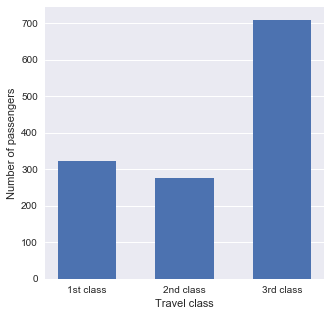

In [14]:
class_data = titanic_data.pclass.value_counts().sort_index()
class_data = class_data.rename(index={1:'1st class', 2:'2nd class', 3:'3rd class'})
pretty_bar(class_data.tolist(), class_data.index, 'Travel class', 'Number of passengers')

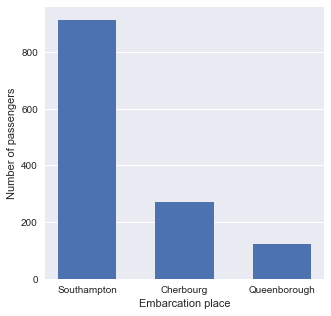

In [15]:
embarcation_data = titanic_data.embarked.value_counts()
embarcation_data = embarcation_data.rename(index={'S':'Southampton', 'C':'Cherbourg', 'Q':'Queenborough'})
pretty_bar(embarcation_data.tolist(), embarcation_data.index, 'Embarcation place', 'Number of passengers')

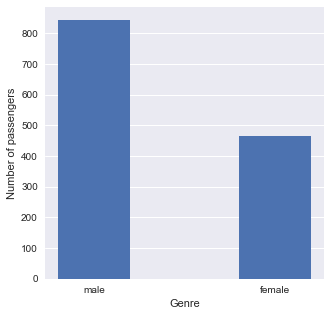

In [16]:
sex_data = titanic_data.sex.value_counts()
pretty_bar(sex_data.tolist(), sex_data.index, 'Genre', 'Number of passengers', width=0.4)

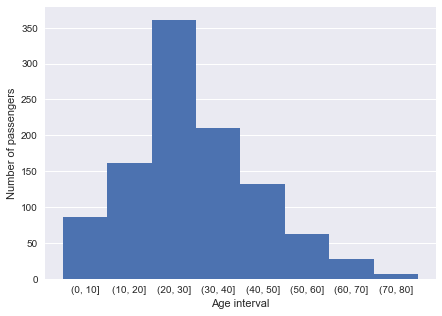

In [17]:
sorted_titanic_data = titanic_data.sort_values(by=['age'])
age_data = pd.cut(sorted_titanic_data.age, range(0,90,10)).value_counts().sort_index()
pretty_bar(age_data.tolist(), age_data.index, 'Age interval', 'Number of passengers', width=1.0, figwidth=7)

## Solution 3
### Task
Calculate the proportion of passengers by cabin floor. Present your results in a pie chart.
#### Assumptions
1. We do not directly compute the proportion. We compute to totals of each category, the pie chart making the implicit proportion computation.

2. We assume the first letter of the cabin field to be the floor (It is actually the deck identifier on the boat). The optional second letter is ignored as it describes a section within the deck.

#### Findings

C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: cabin, dtype: int64


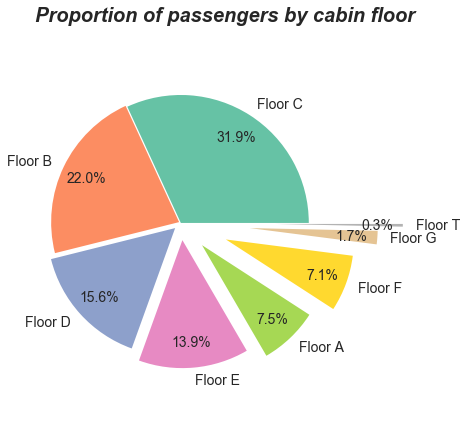

In [18]:
v = titanic_data.cabin.str[0].value_counts()
l = titanic_data.cabin.str[0].value_counts().index
    
print(v)

# Relabel the categories
l = ['Floor '+str(k) for k in l]

pretty_pie('Proportion of passengers by cabin floor', v, l)

## Solution 4
### Task
For each travel class, calculate the proportion of the passengers that survived. Present your results in pie charts.

#### Assumptions
None.
#### Findings

In [19]:
survivors_df = titanic_data[['pclass', 'survived']]

# Number of survivor of each class
survivors_df = survivors_df.groupby('pclass').sum().div( # Divided by
    # the number of passengers of that class
    survivors_df.pclass.value_counts().sort_index(), axis=0)

# Create a column with the difference to 1
survivors_df['died'] = 1.0 - survivors_df.survived
survivors_df = survivors_df.rename(index={1:'1st class', 2:'2nd class', 3:'3rd class'}, level=0)

pretty_pie('Proportion of passengers that survived in first class', survivors_df.iloc[0], survivors_df.iloc[0].index)
pretty_pie('Proportion of passengers that survived in second class', survivors_df.iloc[1], survivors_df.iloc[1].index)
pretty_pie('Proportion of passengers that survived in third class', survivors_df.iloc[2], survivors_df.iloc[2].index)

TypeError: rename() got an unexpected keyword argument "level"

## Solution 5

## Task
Calculate the proportion of the passengers that survived by travel class and sex. Present your results in a single histogram.

### Assumptions
1. The proportion is computed only with respect to the total number of passengers in the corresponding group and not the total number of passenger in the whole boat.

### Findings

In [ ]:
titanic_data['survived'] = titanic_data['survived'].astype(float)
titanic_data['pclass'] = titanic_data['pclass'].astype(float)

survivors_df = titanic_data[['pclass', 'survived', 'sex']]

df = survivors_df.groupby(['pclass', 'sex']).agg(['sum', 'count'])
df.columns = df.columns.droplevel()

df['ratio'] = df['sum'] / df['count']
df = df.rename(index={1:'1st class', 2:'2nd class', 3:'3rd class'}, level=0)

# Aggregate the column index to create a meaningful label for the plot
df = df.reset_index()
df.pclass = df.pclass.astype(str)
df.sex = df.sex.astype(str)
df['Category'] = df.pclass.astype(str).str.cat(' ' + df.sex.astype(str))
df = df.drop(['pclass', 'sex'], axis=1)
df = df.set_index('Category')
df['remainder'] = 1.0 - df.ratio
df = df[['ratio', 'remainder']]

pretty_bar_stacked(df.ratio, df.remainder, df.index, '', '', 'Proportion of passengers that survived per group')

## Solution 6
## Task
Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. Present your results in a DataFrame with unique index.
### Assumptions

### Findings

In [ ]:
titanic_data['survived'] = titanic_data['survived'].astype(float)
titanic_data['pclass'] = titanic_data['pclass'].astype(float)

df = titanic_data.copy()

# Separates into two equally populated groups
df['Age category'] = pd.qcut(df.age, 2, labels=['young', 'old'])
df = df[['Age category', 'pclass', 'survived', 'sex']]

# Group and count
df = df.groupby(['Age category', 'pclass', 'sex']).agg(['sum', 'count'])

df['Survival rate'] = df.survived['sum'] / df.survived['count']
df.columns = df.columns.droplevel(level=1)

# Retain only relevant data
df = df[['Survival rate']]
df.index = df.index.rename(['Age category', 'Travel class', 'Sex'])
print("Is the index unique ? -> " + str(df.index.is_unique))
display(df)